Epoch 1: Train Loss 0.8232 Acc 0.6923 | Val Loss 0.1182 Acc 0.9632 | Precision 0.9501 Recall 0.9535 F1 0.9503 AUC 0.9993


Epoch 2: Train Loss 0.2579 Acc 0.9114 | Val Loss 0.0694 Acc 0.9774 | Precision 0.9714 Recall 0.9744 F1 0.9721 AUC 0.9998


Epoch 3: Train Loss 0.1757 Acc 0.9409 | Val Loss 0.2305 Acc 0.9369 | Precision 0.9325 Recall 0.9526 F1 0.9386 AUC 0.9989


Epoch 4: Train Loss 0.1422 Acc 0.9528 | Val Loss 0.0883 Acc 0.9791 | Precision 0.9714 Recall 0.9791 F1 0.9743 AUC 0.9998


Epoch 5: Train Loss 0.1270 Acc 0.9584 | Val Loss 0.0776 Acc 0.9808 | Precision 0.9815 Recall 0.9828 F1 0.9819 AUC 0.9999


Epoch 6: Train Loss 0.0564 Acc 0.9802 | Val Loss 0.0468 Acc 0.9900 | Precision 0.9877 Recall 0.9912 F1 0.9893 AUC 0.9999


Epoch 7: Train Loss 0.0379 Acc 0.9870 | Val Loss 0.0652 Acc 0.9879 | Precision 0.9860 Recall 0.9892 F1 0.9874 AUC 1.0000


Epoch 8: Train Loss 0.0400 Acc 0.9867 | Val Loss 0.0704 Acc 0.9837 | Precision 0.9838 Recall 0.9827 F1 0.9829 AUC 1.0000


Epoch 9: Train Loss 0.0373 Acc 0.9877 | Val Loss 0.0647 Acc 0.9866 | Precision 0.9828 Recall 0.9875 F1 0.9846 AUC 0.9999


Epoch 10: Train Loss 0.0181 Acc 0.9935 | Val Loss 0.0676 Acc 0.9862 | Precision 0.9817 Recall 0.9876 F1 0.9840 AUC 1.0000


Epoch 11: Train Loss 0.0114 Acc 0.9958 | Val Loss 0.0579 Acc 0.9895 | Precision 0.9910 Recall 0.9917 F1 0.9912 AUC 1.0000


Epoch 12: Train Loss 0.0103 Acc 0.9970 | Val Loss 0.0542 Acc 0.9895 | Precision 0.9895 Recall 0.9916 F1 0.9904 AUC 1.0000
Early stopping triggered after 12 epochs.


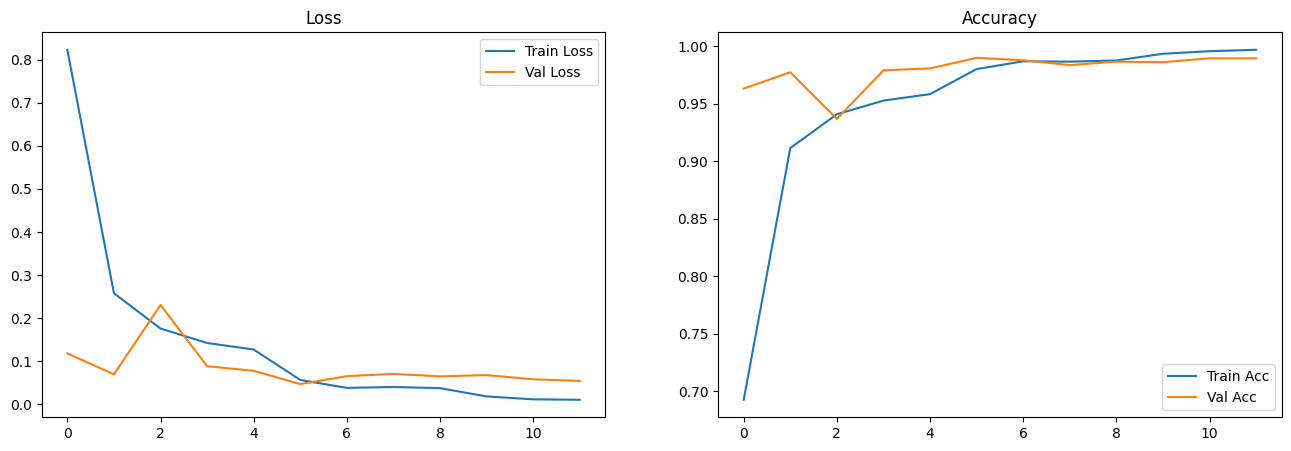

Test: Loss 0.3239 Acc 0.9200 Precision 0.9174 Recall 0.9088 F1 0.9115 AUC 0.9953


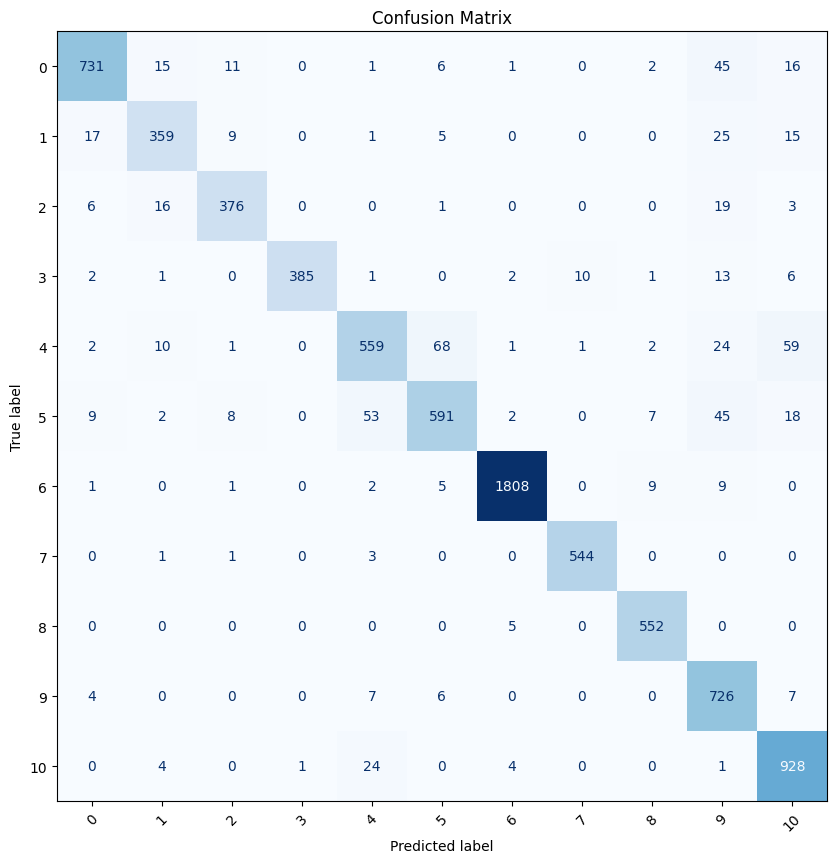

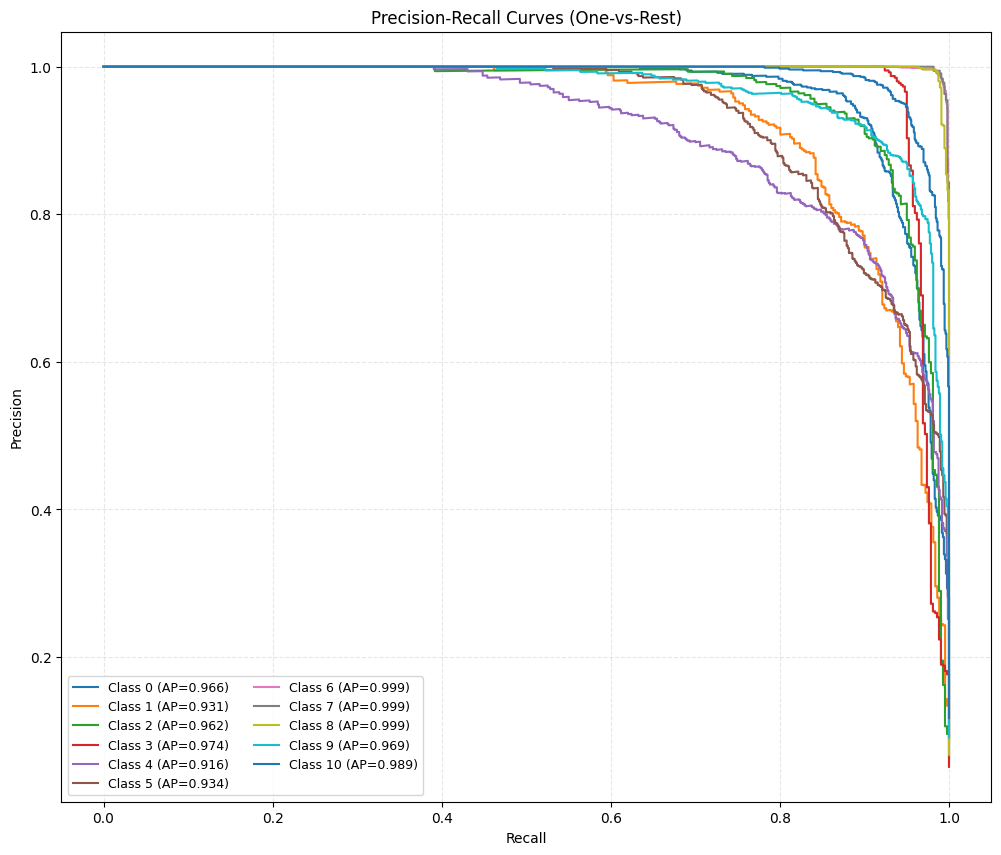

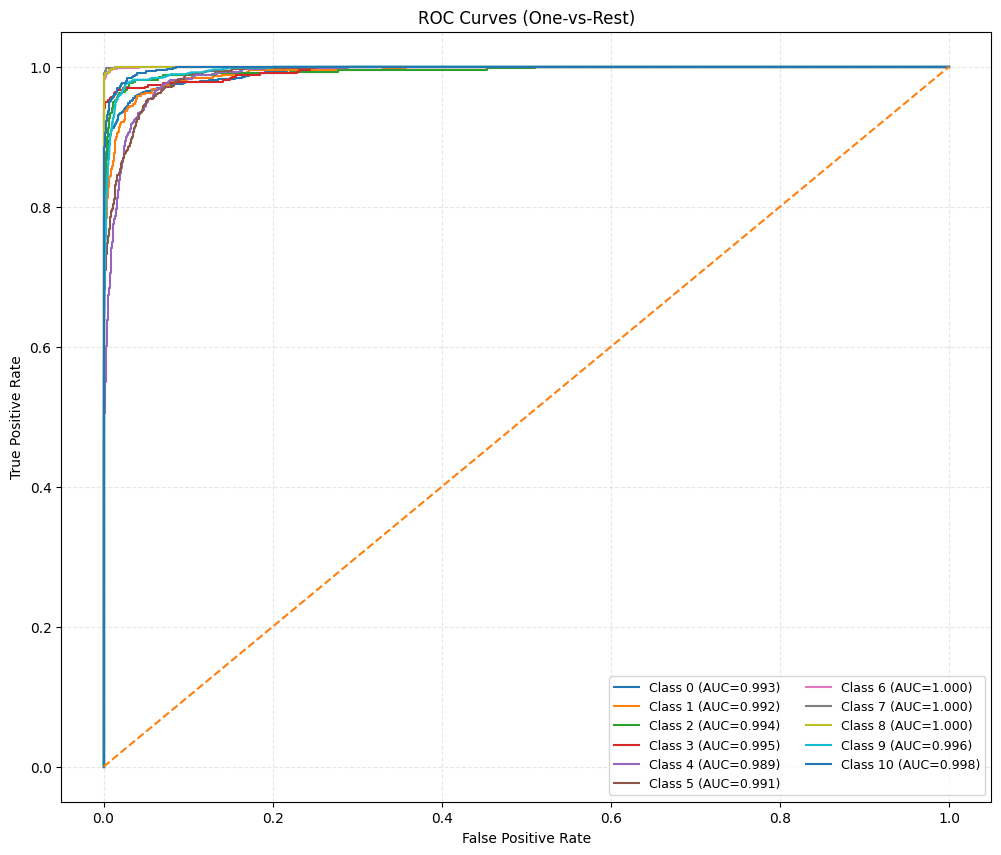

In [7]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
import timm
import numpy as np
import medmnist
from medmnist import INFO

data_flag = 'organcmnist'
info = INFO[data_flag]
num_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
    transforms.ToTensor(),
    transforms.Normalize([.5,.5,.5],[.5,.5,.5]),
    transforms.RandomErasing(p=0.4, scale=(0.02,0.12))
])
transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([.5,.5,.5],[.5,.5,.5])
])

train_dataset = DataClass(split='train', transform=transform_train, download=True)
val_dataset = DataClass(split='val', transform=transform_test, download=True)
test_dataset = DataClass(split='test', transform=transform_test, download=True)

targets = train_dataset.labels
if targets.ndim > 1:
    targets = targets.squeeze()
targets = targets.astype(int)
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
weights = class_weights[targets]
sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

class FracAttn(nn.Module):
    def __init__(self, in_channels, num_heads=8, K=3, alpha=0.5, dropout=0.1):
        super().__init__()
        self.in_channels = in_channels
        self.num_heads = num_heads
        self.head_dim = in_channels // num_heads
        self.K = K
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32))
        self.qkv = nn.Conv2d(in_channels, in_channels*3, kernel_size=1)
        self.proj = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.dropout = nn.Dropout2d(dropout)
        self.laplacian_cache = {}
    def build_laplacian(self, H, W, device):
        key = (H, W, device)
        if key in self.laplacian_cache:
            return self.laplacian_cache[key]
        coords = torch.stack(torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij'), dim=-1).float().to(device)
        coords = coords.view(-1, 2)
        dist = torch.cdist(coords, coords, p=2)
        sigma = 1.0
        A = torch.exp(-dist**2/(2*sigma**2))
        D = torch.diag(A.sum(dim=1))
        L = D - A
        self.laplacian_cache[key] = L
        return L
    def fractional_diffusion(self, L, V):
        lambda_max = torch.linalg.eigvalsh(L).max()
        L_hat = (2 / lambda_max) * L - torch.eye(L.size(0), device=L.device)
        result = V.clone()
        for _ in range(self.K):
            result = torch.matmul(L_hat, result)
        return result
    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(x)
        q, k, v = torch.chunk(qkv, 3, dim=1)
        q = q.reshape(B, self.num_heads, self.head_dim, H*W).permute(0,1,3,2).reshape(B*self.num_heads, H*W, self.head_dim)
        k = k.reshape(B, self.num_heads, self.head_dim, H*W).permute(0,1,3,2).reshape(B*self.num_heads, H*W, self.head_dim)
        v = v.reshape(B, self.num_heads, self.head_dim, H*W).permute(0,1,3,2).reshape(B*self.num_heads, H*W, self.head_dim)
        attn = torch.matmul(q, k.transpose(-2,-1)) / (self.head_dim ** 0.5)
        attn = F.softmax(attn, dim=-1)
        attn_out = torch.matmul(attn, v)
        attn_out = attn_out.reshape(B, self.num_heads, H*W, self.head_dim).transpose(1,2).reshape(B, H*W, C)
        L = self.build_laplacian(H, W, x.device)
        v_diffused = self.fractional_diffusion(L, v)
        v_diffused = v_diffused.reshape(B, self.num_heads, H*W, self.head_dim).transpose(1,2).reshape(B, H*W, C)
        out = self.alpha*attn_out + (1-self.alpha)*v_diffused
        out = out.transpose(1,2).reshape(B, C, H, W)
        out = self.proj(out)
        out = self.dropout(out)
        return out

class FracNet(nn.Module):
    def __init__(self, num_classes=num_classes, dropout=0.5):
        super().__init__()
        vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.patch_embed = vit.patch_embed
        self.cls_token = vit.cls_token
        self.pos_embed = vit.pos_embed
        self.pos_drop = vit.pos_drop
        self.blocks = vit.blocks
        self.norm = vit.norm
        self.attn = FracAttn(768)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, num_classes)
    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        x = x[:, 1:]
        H = W = int(x.shape[1] ** 0.5)
        x = x.permute(0,2,1).reshape(B, 768, H, W)
        x = self.attn(x)
        x = x.mean([-2, -1])
        x = self.dropout(x)
        out = self.classifier(x)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FracNet(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

train_losses, val_losses, train_accs, val_accs = [], [], [], []

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0,0,0
    loop = tqdm(loader, desc='Training', leave=False)
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        y = y.view(-1).long()
        if y.numel() == 0:
            continue
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        loop.set_postfix(loss=loss.item(), acc=correct/total)
    return total_loss/len(loader.dataset), correct/total if total > 0 else 0.0

def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0,0,0
    all_targets, all_probs = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            y = y.view(-1).long()
            if y.numel() == 0:
                continue
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            probs = torch.softmax(out, dim=1)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            all_targets.append(y.cpu())
            all_probs.append(probs.cpu())
    if total == 0:
        return float('inf'), 0.0, 0.0, 0.0, 0.0, float('nan'), [], [], []
    all_targets = torch.cat(all_targets).numpy()
    all_probs = torch.cat(all_probs).numpy()
    preds = all_probs.argmax(axis=1)
    precision = precision_score(all_targets, preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, preds, average='macro', zero_division=0)
    y_true_bin = label_binarize(all_targets, classes=np.arange(num_classes))
    auc_per_class = []
    for c in range(num_classes):
        if np.sum(y_true_bin[:,c]) > 0 and np.sum(y_true_bin[:,c] == 0) > 0:
            auc_per_class.append(roc_auc_score(y_true_bin[:,c], all_probs[:,c]))
    auc_macro = np.mean(auc_per_class) if len(auc_per_class) > 0 else float('nan')
    return total_loss/len(loader.dataset), correct/total, precision, recall, f1, auc_macro, all_targets, all_probs, preds

early_stopping_patience = 6
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_path = 'best_model_organcmnist.pth'

for epoch in range(25):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, precision, recall, f1, auc_macro, all_targets, all_probs, all_preds = validate_epoch(model, val_loader, criterion, device)
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f} | Precision {precision:.4f} Recall {recall:.4f} F1 {f1:.4f} AUC {auc_macro:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(train_losses,label='Train Loss')
plt.plot(val_losses,label='Val Loss')
plt.legend()
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(train_accs,label='Train Acc')
plt.plot(val_accs,label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

model.load_state_dict(torch.load(best_model_path))
test_loss, test_acc, precision, recall, f1, auc_macro, all_targets, all_probs, all_preds = validate_epoch(model, test_loader, criterion, device)
print(f"Test: Loss {test_loss:.4f} Acc {test_acc:.4f} Precision {precision:.4f} Recall {recall:.4f} F1 {f1:.4f} AUC {auc_macro:.4f}")

if len(all_targets) > 0:
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(num_classes)])
    disp.plot(ax=plt.gca(), xticks_rotation=45, cmap='Blues', colorbar=False)
    plt.title('Confusion Matrix')
    plt.show()
    y_true_bin = label_binarize(all_targets, classes=np.arange(num_classes))
    plt.figure(figsize=(12,10))
    for c in range(num_classes):
        precision_c, recall_c, _ = precision_recall_curve(y_true_bin[:,c], all_probs[:,c])
        ap_c = auc(recall_c, precision_c)
        plt.plot(recall_c, precision_c, label=f'Class {c} (AP={ap_c:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves (One-vs-Rest)')
    plt.legend(ncol=2, fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()
    plt.figure(figsize=(12,10))
    for c in range(num_classes):
        fpr_c, tpr_c, _ = roc_curve(y_true_bin[:,c], all_probs[:,c])
        roc_auc_c = auc(fpr_c, tpr_c)
        plt.plot(fpr_c, tpr_c, label=f'Class {c} (AUC={roc_auc_c:.3f})')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.legend(ncol=2, fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()